Lab 02
===========

## Context

### Convolutional Neural Network(CNN)
+ Convolution
+ Kernel
+ Stride
+ Padding
+ Pooling

## 합성곱 신경망(Convolutional Neural Network)
합성곱 신경망은 커널과 이미지의 **합성곱**을 이용하여 이미지의 특징점을 찾아내고 이를 입력신호로 신경망을 사용하는 신경망입니다.

![CNN](Images/CNN.png)

### 합성곱
합성곱이란 두 함수 f, g 가운데 하나의 함수를 반전(reverse), 전이(shift)시킨 다음, 다른 하나의 함수와 곱한 결과를 합하는 것을 의미합니다. 이를 그림으로 표현하면 아래와 같습니다.

![Convolution](Images/Convolution.gif)

### 커널
이미지의 특징점을 찾기위해서는 해당 특징점을 위한 **커널**이 필요합니다. 이러한 커널은 일반적으로 행열의 형태를 띄며 합성곱 결과가 클 수록 해당 특징점에 가깝다는 것을 의미합니다.

### Stride
Stride란 얼마나 촘촘하게 특징점을 찾기위한 합성곱을 수행할 것인지입니다. 예를 들어 위의 합성곱의 이해를 돕기 위한 이미지는 3X3 커널을 Stride를 1로 합성곱을 수행한 것입니다. Stride값이 1에 가까울 수록 연산량은 많아지지만 더 촘촘하게 특징점을 찾게 됩니다.

### 패딩
일반적으로 커널은 3X3이상의 크기를 가지게 됩니다. 이에 따라 가장자리에 가까울 수록 커널에 의해 검증되는 횟수가 줄어들게 됩니다. 이러한 문제를 해결하기 위해 등장한 개념으로 가장자리의 점도 커널에 의해 검증되도록 이미지를 확장하고 확장된 부분에 0으로 채워 특징으로 잡히지 않도록 합니다.

아래 그림은 상하좌우에 2줄의 패딩을 삽입한 결과입니다.

![padding](Images/zero-padding.png)

### 풀링
합성곱의 결과로 추출된 특징들은 모두 사용될 필요가 없습니다. 특히 합성곱의 결과가 작을 수록 해당 특징에 부합되지 않는다는 것이기 때문에 합성곱의 결과를 줄일 수 있습니다. 이러한 과정을 통해 우리는 합성곱 신경망의 연산량을 줄일 수 있습니다.

아래 그림은 2X2 Stride 2로 최대값 풀링과 평균값 풀링을 수행한 후 결과입니다.

![pooling](Images/pooling.png)

In [1]:
from os.path import join

import numpy as np

from sklearn.model_selection import train_test_split

import keras
from keras import layers
from keras import models
import tensorflow as tf

import matplotlib.pyplot as plt

datapath = join('data', 'cifar')

Using TensorFlow backend.


In [2]:
# Keras 백 엔드인 TensorFlow의 세션 설정을 불러옵니다.
from keras.backend.tensorflow_backend import set_session

# TensorFlow의 ConfigProto() 객체에 학습시 적용할 옵션들을 명시적으로 설정할 수 있습니다.
config = tf.ConfigProto()
# GPU 옵션으로 allow_grouth를 True로 설정합니다.
config.gpu_options.allow_growth = True 

# TensorFlow는 Session이라는 실행 단위를 가지고 있는데, 해당 Session이라는에 적용할 옵션을 담고있는 Config객체를 전달합니다.
sess = tf.Session(config=config)
# 설정한 Session이라는을 현재 프로세스에 적용합니다.
set_session(sess)  

## 1. 데이터 살펴보기
이번에 사용할 데이터는 조심히 발음해야하는 CIFAR-10 데이터셋 입니다.<br>
해당 데이터셋은 10개의 클래스로 이루어진 6만개의 32*32 RGB 컬러 이미지입니다.<br>
MNIST와 동일하게 일반적으로 머신러닝 알고리즘 및 컴퓨터 비전 분야에서 널리 사용되는 데이터 중 하나 입니다<br>
실습의 편의를 위해 데이터는 numpy 행렬로 변환되어 저장된 상태입니다.<br>


#### 레이블 설명
0.비행기(airplane)<br>
1.자동차(automobile)<br>
2.새(bird)<br>
3.고양이(cat)<br>
4.사슴(deer)<br>
5.개(dog)<br>
6.개구리(frog)<br>
7.말(horse)<br>
8.배(ship)<br>
9.트럭(truck)<br>

In [3]:
#데이터 불러오기
x = np.load(join(datapath,'cifar-10_data.npy'))
y = np.load(join(datapath,'cifar-10_label.npy'))

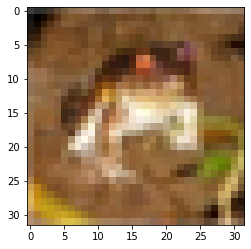

In [4]:
plt.imshow(x[0])

## 2. 간단한 전처리
CIFAR-10 데이터는 32*32*3에 픽셀마다 0~255 범위의 값을 가진 행렬입니다.
각 픽셀에 대해 0~1 사이의 값을 갖도록 255로 나누어 줍니다.

In [5]:
#0~1 사이의 값으로 변경
x = x/255

#값이 잘 변화되었는지 확인
print('최대 : {}, 최소 : {}'.format(np.max(x), np.min(x)))

최대 : 1.0, 최소 : 0.0


이미지들의 정답을 나타내는 label 데이터는 0~9의 값을 가지고 있습니다.<br>
해당 label 데이터도 독립적인 벡터 형태로 표현하겠습니다.

### 왜 벡터를 사용하나요
여기에서 Label 데이터를 그대로 숫자로 표현해도 되지만, 벡터로 표현한 것은 숫자 이미지라는 특성이 수치적으로 1씩 증가하는 관계가 아니기 때문에<br>
서로 독립적인 관계를 갖는 벡터로 표현해주는 것이 더 적절합니다. 이러한 기법을 One-hot encoding이라 합니다.<br>
Keras에서는 연속 정수형을 벡터형태로 변환해주는 to_categorical() 함수가 존재합니다.

In [6]:
print(y[0])
y = keras.utils.to_categorical(y)
print(y[0])

[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


데이터를 학습 데이터와 검증 데이터로 나눕니다.

In [7]:
#x, y를 학습 데이터 67% 검증 데이터 33%로 나눕니다.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=2019)

입력 변수와 결과물이 어떤 크기를 가지는지 확인해봅니다.

In [8]:
x_train.shape

(40200, 32, 32, 3)

In [9]:
y_train.shape

(40200, 10)

## 3. Convolutional Neural Network 사용해보기

### 3-1 파라미터 세팅

In [10]:
#한 루프당 올릴 데이터의 수
batch_size=1024
#총 사이클의 수
epoch=10

### 3-2 입력층 만들기

In [11]:
# 입력층
input_shape = (x_train[0].shape)
input_tensor = layers.Input(input_shape)

### 3-3 모델 구조 만들기

In [12]:
#Convolutional Layer로 3*3의 크기의 필터, 활성화 함수로 relu, 입력 차원과 출력 차원이 같아지도록 padding을 사용합니다.
conv_layer_1 = layers.Conv2D(32, (3,3), activation = 'relu', padding='same')(input_tensor)
#Pooling Layer로 Maxpooling을 수행합니다. 기본값으로 2*2의 사이즈로 수행합니다.
pool_layer_1 = layers.MaxPooling2D()(conv_layer_1)
#Dropout Layer로 모든 신경을 사용하는 것이 아니라 50%의 신경만 사용합니다.
drop_out_layer_1 = layers.Dropout(0.5)(pool_layer_1)
#BatchNormalization Layer로 Vanishing Gradient문제를 해결하고자 사용합니다.
batch_normal_1 = layers.BatchNormalization()(drop_out_layer_1)

conv_layer_2 = layers.Conv2D(64, (3,3), activation = 'relu', padding='same')(batch_normal_1)
pool_layer_2 = layers.MaxPooling2D()(conv_layer_2)
drop_out_layer_2 = layers.Dropout(0.5)(pool_layer_2)
batch_normal_2 = layers.BatchNormalization()(drop_out_layer_2)

conv_layer_3 = layers.Conv2D(128, (3,3), activation = 'relu', padding='same')(batch_normal_2)
drop_out_layer_3 = layers.Dropout(0.5)(conv_layer_3)
batch_normal_3 = layers.BatchNormalization()(drop_out_layer_3)

conv_layer_4 = layers.Conv2D(256, (3,3), activation = 'relu', padding='same')(batch_normal_3)
drop_out_layer_4 = layers.Dropout(0.5)(conv_layer_4)
batch_normal_4 = layers.BatchNormalization()(drop_out_layer_4)

#이제 까지 만들어진 특징점을 1차원 벡터로 펼쳐주는 Layer입니다.
flat = layers.Flatten()(batch_normal_4)

#앞의 MLP에서 사용한 것과 같은 Layer로 FullyConnected Layer와 relu활성화 함수를 사용합니다.
dense_layer_1 = layers.Dense(512, activation='relu')(flat)
#Dropout Layer로 모든 신경을 사용하는 것이 아니라 50%의 신경만 사용합니다.
drop_out_layer_5 = layers.Dropout(0.5)(dense_layer_1)
#BatchNormalization Layer로 Vanishing Gradient문제를 해결하고자 사용합니다.
batch_normal_5 = layers.BatchNormalization()(drop_out_layer_5)

dense_layer_2 = layers.Dense(256, activation='relu')(batch_normal_5)
drop_out_layer_6 = layers.Dropout(0.5)(dense_layer_2)
batch_normal_6 = layers.BatchNormalization()(drop_out_layer_6)

dense_layer_3 = layers.Dense(128, activation='relu')(batch_normal_5)
drop_out_layer_7 = layers.Dropout(0.5)(dense_layer_3)
batch_normal_7 = layers.BatchNormalization()(drop_out_layer_7)

# 출력층
output_tensor = layers.Dense(10, activation='softmax')(batch_normal_7)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
# 모델 정의
model = models.Model(input_tensor, output_tensor)

# 모델 생성(컴파일) Adam 최적화기와 Categorical Crossentropy 비용함수를 사용합니다.
model.compile(optimizer = 'Adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

### 3-4 모델 확인하기

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

### 3-5 모델 학습하기

In [15]:
history = model.fit(x_train, y_train, 
          validation_data=[x_test, y_test],
          batch_size=batch_size,
          epochs=epoch,
          verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 40200 samples, validate on 19800 samples
Epoch 1/10
 - 7s - loss: 2.3419 - acc: 0.2224 - val_loss: 3.0996 - val_acc: 0.2014
Epoch 2/10
 - 3s - loss: 1.8522 - acc: 0.3357 - val_loss: 2.4372 - val_acc: 0.2825
Epoch 3/10
 - 3s - loss: 1.6690 - acc: 0.3911 - val_loss: 2.2142 - val_acc: 0.3358
Epoch 4/10
 - 3s - loss: 1.5573 - acc: 0.4323 - val_loss: 2.1864 - val_acc: 0.3644
Epoch 5/10
 - 3s - loss: 1.4703 - acc: 0.4660 - val_loss: 2.8309 - val_acc: 0.2996
Epoch 6/10
 - 3s - loss: 1.4061 - acc: 0.4959 - val_loss: 2.6328 - val_acc: 0.3180
Epoch 7/10
 - 3s - loss: 1.3573 - acc: 0.5123 - val_loss: 2.0184 - val_acc: 0.4048
Epoch 8/10
 - 3s - loss: 1.2986 - acc: 0.5352 - val_loss: 2.3032 - val_acc: 0.3682
Epoch 9/10
 - 3s - loss: 1.2533 - acc: 0.5553 - val_loss: 2.0553 - val_acc: 0.4143
Epoch 10/10
 - 3s - loss: 1.2104 - acc: 0.5708 - val_loss: 1.7219 - val_acc: 0.4688


### 3-6 결과 확인
학습된 결과를 그래프로 그려서 확인해보겠습니다.

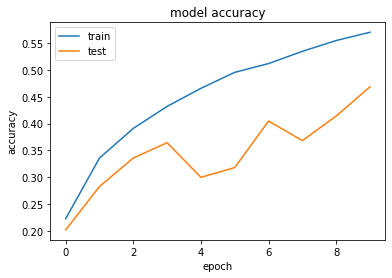

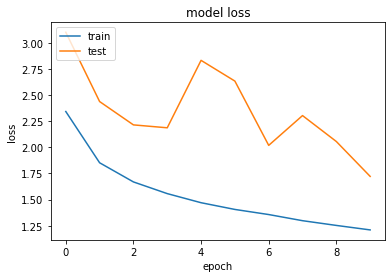

In [16]:
#학습 데이터와 검증 데이터의 정확도를 그래프로 출력합니다.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#학습 데이터와 검증 데이터의 비용함수 값을 그래프로 출력합니다.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Reference
- 합성곱 : https://ko.wikipedia.org/wiki/합성곱